In [20]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import string
import os
import re
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.layers import TextVectorization, Embedding, Dropout, Dense, Dropout, Bidirectional, LSTM, Input, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
# defining train and test dataset directories
train_dir = '/home/devcontainers/Datasets/train'
test_dir = '/home/devcontainers/Datasets/test'
os.listdir(train_dir)

['pos', 'neg']

In [60]:
batch_size = 64
seed = 42
maxLen = 200
vocab_size = 10000
embedding_dim = 25

In [77]:
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)
val_ds = text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [75]:
def standardize_texts(data):
    lowercase = tf.strings.lower(data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

vectorize_layer = TextVectorization(standardize=standardize_texts, max_tokens=vocab_size, output_mode='int', output_sequence_length=maxLen)

In [78]:
train_text = train_ds.map(lambda x, y : x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train = train_ds.map(vectorize_text)
val = val_ds.map(vectorize_text)
test = test_ds.map(vectorize_text)

In [79]:
print(vectorize_layer.get_vocabulary()[10])
print(vectorize_layer.get_vocabulary()[100])
print(vectorize_layer.get_vocabulary()[1000])
print(vectorize_layer.get_vocabulary()[9999])

i
characters
political
rushes


In [65]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [82]:
input = Input(shape=(maxLen,))
emb = Embedding(vocab_size, embedding_dim)(input)
x = Dropout(0.2)(emb)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(input, output)

In [83]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 200, 25)        │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 200, 25)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 25)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,457 (990.07 KB)

 Trainable params: 253,457 (990.07 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(threshold=0.5)])
checkpoint = ModelCheckpoint('text_classifier_imdb2.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
history = model.fit(train, batch_size=batch_size, epochs=10, validation_data=val, callbacks=[checkpoint])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.6274 - loss: 0.6389
Epoch 1: val_loss improved from inf to 0.37125, saving model to text_classifier_imdb2.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - binary_accuracy: 0.6278 - loss: 0.6386 - val_binary_accuracy: 0.8364 - val_loss: 0.3712
Epoch 2/10
306/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8539 - loss: 0.3437
Epoch 2: val_loss improved from 0.37125 to 0.33539, saving model to text_classifier_imdb2.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - binary_accuracy: 0.8542 - loss: 0.3432 - val_binary_accuracy: 0.8508 - val_loss: 0.3354
Epoch 3/10
305/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8890 - loss: 0.2755
Epoch 3: val_loss improved from 0.33539 to 0.30385, saving model to text_classifier_imdb2.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - binary_accuracy: 0.8891 - loss: 0.2751 - val_binary_accuracy: 0.8716 - val_loss: 0.3039
Epoch 4/10
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9063 - loss: 0.2365
Epoch 4: val_loss did not improve from 0.30385
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - binary_accuracy: 0.9063 - loss: 0.2363 - val_binary_accuracy: 0.8580 - val_loss: 0.3280
Epoch 5/10
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9248 - loss: 0.2008
Epoch 5: val_loss did not improve from 0.30385
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - binary_accuracy: 0.9248 - loss: 0.2008 - val_binary_accuracy: 0.8712 - val_loss: 0.3174
Epoch 6/10
305/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9369 - loss: 0.1737
Epoch 6: val_loss did not improve from 0.30385
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - binary_accuracy: 0.9368 - loss: 0.1737 - val_binary_accuracy: 0.8680 - val_loss: 0.3377
Epoch 7/10
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - b

In [85]:
loss, accuracy = model.evaluate(test)
print(loss)
print(accuracy)

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - binary_accuracy: 0.8319 - loss: 0.5061
0.5048485398292542
0.8345199823379517


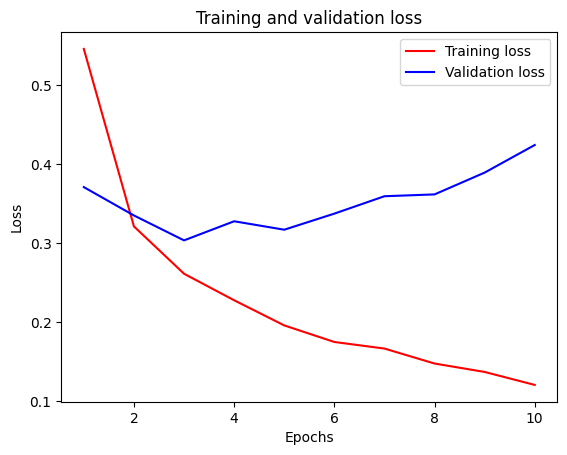

In [87]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

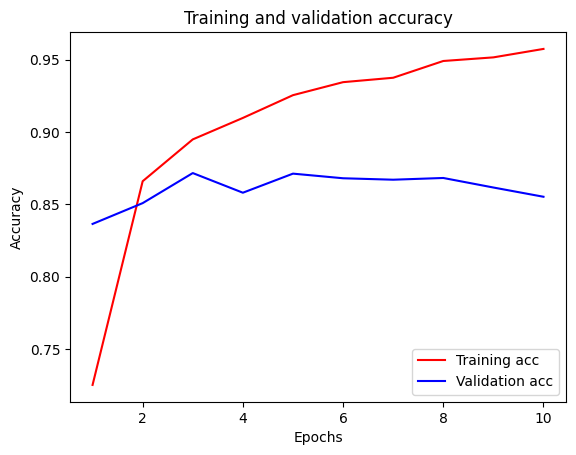

In [88]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()